Import the neccessary libraries

In [1]:
import yfinance as yf # Library to download historical stock data
import pandas as pd # Data manipulation and analysis library
import numpy as np # Numerical operations, especially for feature engineering
import matplotlib.pyplot as plt # Plotting library for visualizations
import seaborn as sns # Enhanced data visualization library
from sklearn.preprocessing import StandardScaler # Tool to standardize features
from sklearn.decomposition import PCA # Principal Component Analysis for dimensionality reduction (for 2D plotting)
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN # The three clustering algorithms to compare
from sklearn.metrics import silhouette_score # Evaluation metric for clustering

Data Acquistion

In [2]:
# Define a diverse list of stock tickers from various sectors
TICKERS = ["AAPL","MSFT","GOOGL","AMZN","JPM","JNJ","KO","KO","XOM","TSLA","NFLX"]
# Define the date range for the historical data
START_DATE = "2020-01-01"
END_DATE = None

In [4]:
# Download the historical Adjusted Close prices for the defined tickers
print(f"Downloading data for {len(TICKERS)} stocks from {START_DATE} to {END_DATE}.........")
# The Adj Close price is used as it accounts for dividends and stock splits
stock_data = yf.download(TICKERS,start=START_DATE,end=END_DATE)

C:\Users\Dell\AppData\Local\Temp\ipykernel_12112\1035598903.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(TICKERS,start=START_DATE,end=END_DATE)
[*********************100%***********************]  10 of 10 completed


In [5]:
# Fill any potential missing values (NaN) that may occur due to market closures or data gaps
# ffill (forward fill) propagates the last valid observation forward
stock_data = stock_data.fillna(method="ffill")
print("----- Stock Data Head (Adjusted Close Prices) -----")
stock_data.head()

----- Stock Data Head (Adjusted Close Prices) -----


C:\Users\Dell\AppData\Local\Temp\ipykernel_12112\2928494628.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method="ffill")


Price           Close                        ...   Volume                     
Ticker           AAPL       AMZN      GOOGL  ...     NFLX       TSLA       XOM
Date                                         ...                              
2020-01-02  72.538513  94.900497  67.965233  ...  4485800  142981500  12456400
2020-01-03  71.833298  93.748497  67.609680  ...  3806900  266677500  17386900
2020-01-06  72.405678  95.143997  69.411766  ...  5663100  151995000  20081900
2020-01-07  72.065155  95.343002  69.277679  ...  4703200  268231500  17387700
2020-01-08  73.224411  94.598503  69.770782  ...  7104500  467164500  15137700

[5 rows x 50 columns]

Data Preprocessing

In [7]:
df = stock_data

In [8]:
df

Price            Close                          ...   Volume                     
Ticker            AAPL        AMZN       GOOGL  ...     NFLX       TSLA       XOM
Date                                            ...                              
2020-01-02   72.538513   94.900497   67.965233  ...  4485800  142981500  12456400
2020-01-03   71.833298   93.748497   67.609680  ...  3806900  266677500  17386900
2020-01-06   72.405678   95.143997   69.411766  ...  5663100  151995000  20081900
2020-01-07   72.065155   95.343002   69.277679  ...  4703200  268231500  17387700
2020-01-08   73.224411   94.598503   69.770782  ...  7104500  467164500  15137700
...                ...         ...         ...  ...      ...        ...       ...
2025-10-27  268.809998  226.970001  269.269989  ...  4691100  105867500  10975400
2025-10-28  269.000000  229.250000  267.470001  ...  4020900   80185700   9535200
2025-10-29  269.700012  230.300003  274.570007  ...  3399500   67983500  12570600
2025-10-30  271.399994  222.860001  281.480011  ...  4063300   72128500  16156400
2025-10-31  271.475006  246.824997  281.160004  ...  4455765   57170149  10589763

[1467 rows x 50 columns]

In [10]:
# Check for missing values
df_missing = df.isnull().sum()
print("----- Missing Values -----")
print(df_missing)

----- Missing Values -----
Price   Ticker
Close   AAPL      0
        AMZN      0
        GOOGL     0
        JNJ       0
        JPM       0
        KO        0
        MSFT      0
        NFLX      0
        TSLA      0
        XOM       0
High    AAPL      0
        AMZN      0
        GOOGL     0
        JNJ       0
        JPM       0
        KO        0
        MSFT      0
        NFLX      0
        TSLA      0
        XOM       0
Low     AAPL      0
        AMZN      0
        GOOGL     0
        JNJ       0
        JPM       0
        KO        0
        MSFT      0
        NFLX      0
        TSLA      0
        XOM       0
Open    AAPL      0
        AMZN      0
        GOOGL     0
        JNJ       0
        JPM       0
        KO        0
        MSFT      0
        NFLX      0
        TSLA      0
        XOM       0
Volume  AAPL      0
        AMZN      0
        GOOGL     0
        JNJ       0
        JPM       0
        KO        0
        MSFT      0
        NFLX      

In [11]:
# Check for duplicated rows
df_duplicated = df.duplicated().sum()
print("----- Duplicated Rows -----")
print(df_duplicated)

----- Duplicated Rows -----
0


In [12]:
# Check the shape of the data
print("----- Shape of the Data -----")
print(df.shape)

----- Shape of the Data -----
(1467, 50)


Feature Engineering

In [13]:
# Calculate Daily Lag Returns
# Log returns are preferred over simple returns in finance for stationary and additive properties
log_returns = np.log(df / df.shift(1)).dropna()

In [14]:
# Calculate Annualized Mean Returns (Performance Features)
# Assumes approximately 252 trading days in a year
# Multiply the daily mean return by 252
mean_return = log_returns.mean() * 252

In [15]:
# Calculate Annualized Volatility (Risk Feature)
# Volatility is the Standard deviation of returns
# Multiply the daily standard devaition by the square root of 252
volatility = log_returns.std() * np.sqrt(252)

In [16]:
# Combine the two engineered features into a single DataFrame for clustering
features_df = pd.DataFrame({
    "Mean Return":mean_return,
    "Volatility":volatility
})

In [17]:
print("Engineered Features (Annualized Risk/Return):")
print(features_df)

Engineered Features (Annualized Risk/Return):
               Mean Return  Volatility
Price  Ticker                         
Close  AAPL       0.226861    0.321012
       AMZN       0.164307    0.359565
       GOOGL      0.244080    0.325140
       JNJ        0.071848    0.196974
       JPM        0.164326    0.315206
       KO         0.069113    0.205166
       MSFT       0.209882    0.297738
       NFLX       0.210546    0.453093
       TSLA       0.473320    0.668732
       XOM        0.129647    0.331552
High   AAPL       0.230379    0.270900
       AMZN       0.166848    0.318765
       GOOGL      0.247014    0.284929
       JNJ        0.072316    0.166088
       JPM        0.165328    0.274698
       KO         0.067980    0.175279
       MSFT       0.213467    0.240116
       NFLX       0.212335    0.389897
       TSLA       0.475966    0.595411
       XOM        0.129357    0.295117
Low    AAPL       0.228367    0.288957
       AMZN       0.165894    0.335737
       GOOGL      

In [18]:
# Extract the values (X) for scaling and modelling
X = features_df.values

Data Scaling

In [19]:
# Standardize the features
# Scaling is cruical for distance-based algorithms (K-Means,Agglomerative)
# It ensures that no single feature dominates the distance calculation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Apply PCA for 2D Visualization
# We reduce the 2 features down to 2 principal components (although redundant here,
# this step is standard practice for generalizing to higher dimension)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca,index=features_df.index,columns=["PC1","PC2"])

Pre-Training Visualization

C:\Users\Dell\AppData\Local\Temp\ipykernel_12112\3590024146.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(ticker,(pca_df["PC1"][i] + 0.05,pca_df["PC2"][i]),fontsize=10)


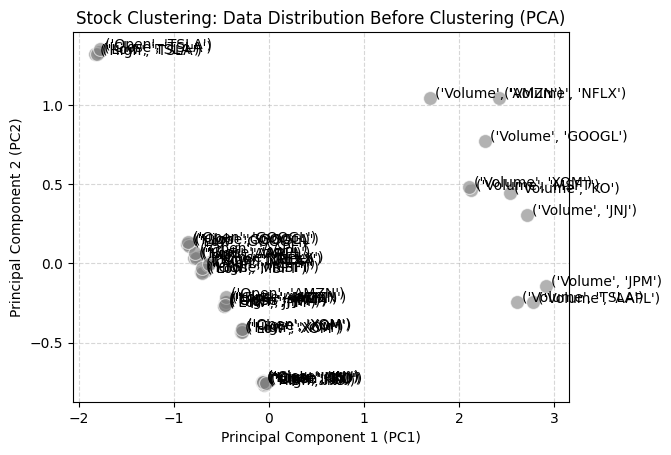

In [21]:
plt.Figure(figsize=(10,6))
# Create a scatter plot of the stocks in the PC1 vs PC2 space
sns.scatterplot(x=pca_df["PC1"],y=pca_df["PC2"],s=100,color="grey",alpha=0.6)
# Add labels for each ticker on the plot
for i,ticker in enumerate(pca_df.index):
    plt.annotate(ticker,(pca_df["PC1"][i] + 0.05,pca_df["PC2"][i]),fontsize=10)
plt.title('Stock Clustering: Data Distribution Before Clustering (PCA)')
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.grid(True,linestyle="--",alpha=0.5)
plt.show()

Hyperparameter Tuning and Model Comparison

In [25]:
# Dictionary to store the results for comparison
results = {}
best_score = -1
best_model_name = ""
best_model = None

----- K-Means Elbow Method Tuning -----


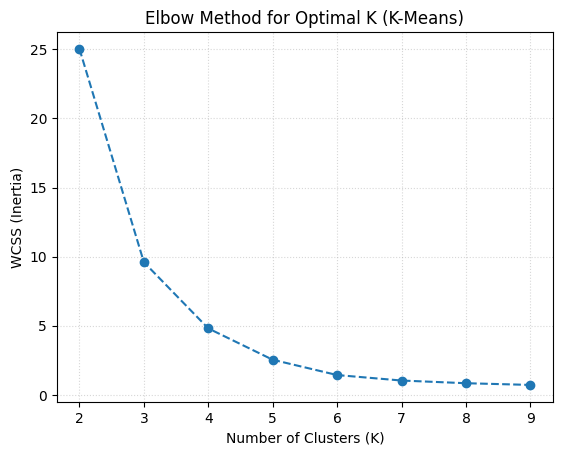

In [26]:
# ----- K-Means Clustering and Tunin (Elbow Method) -----
# Elbow Method to find the optimal K (number of clusters)
wcss = [] # WCSS (Within-Cluster Sum of Squares) list
k_range = range(2,min(10,len(TICKERS))) # Check K values from 2 up to the number of tickers
print("----- K-Means Elbow Method Tuning -----")

for k in k_range:
    # Initialize KMeans with k clusters, using "k-means++" for smart centroid initialization
    kmeans = KMeans(n_clusters=k,random_state=42,n_init="auto")
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_) # "inertia_ is the WCSS value"

# Plot WCSS to find the "elbow" (the point where the decrease rate slows down)
plt.Figure(figsize=(8,4))
plt.plot(k_range,wcss,marker="o",linestyle="--")
plt.title("Elbow Method for Optimal K (K-Means)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Inertia)")
plt.grid(True,linestyle=":",alpha=0.5)
plt.show()

In [27]:
# Based on visualization (or heuristic, we pick a reasonable K=3)
optimal_k = 3
# Heuristic selection based on typical financial groupings (High-Risk/Return, Low-Risk/Return, Mid-Range)

# Final K-Means Model
kmeans_model = KMeans(n_clusters=optimal_k,random_state=42,n_init="auto").fit(X_scaled)
kmeans_score = silhouette_score(X_scaled,kmeans_model.labels_)
results["K-Means"] = {
    "Score":kmeans_score,
    "Labels":kmeans_model.labels_
}
print(f"K-Means (K={optimal_k}) Silhouette Score: {kmeans_score:>4f}")

K-Means (K=3) Silhouette Score: 0.776832


In [28]:
# Update best model
if kmeans_score > best_score:
    best_score = kmeans_score
    best_model_name = "K-Means"
    best_model = kmeans_model

In [29]:
# ----- Hierarachical Clustering -----
# Hierarchical Clustering (Agglomerative) does not strictly need K,
# but for Silhouette Score Comparison, we use same optimal_k from K-Means
hierarchical_model = AgglomerativeClustering(n_clusters=optimal_k,linkage="ward").fit(X_scaled)
# "ward" linkage minimizes the variane of the Clusters being merged
hierarchical_score = silhouette_score(X_scaled,hierarchical_model.labels_)
results["Hierarchical"] = {
    "Score":hierarchical_score,
    "Labels":hierarchical_model.labels_
}
print(f"Hierarchical (k={optimal_k}) Silhouette Score: {hierarchical_score:.4f}")

Hierarchical (k=3) Silhouette Score: 0.7768


In [30]:
# Update best model
if hierarchical_score > best_score:
    best_score = hierarchical_score
    best_model_name = "Hierarchical"
    best_model = hierarchical_model

In [32]:
# ----- DSCAN Clustering and Tuning
# DBSCAN tuning involves finding optimal epilson (eps) and minimum samples (min_samples)
# We test a few common settings and select the best one based on Silhouette Score
# Note: DBSCAN often performs poorly on this type of data (global density) and may produce many noise points (-1 labels)
dbscan_parameters = [
    (0.5,2), # (eps,min_samples)
    (0.6,2),
    (0.4,3)
]
best_dbscan_score = -1

for eps,min_pts in dbscan_parameters:
    dbscan_model = DBSCAN(eps=eps,min_samples=min_pts).fit(X_scaled)
    # Exclude noise points (-1) from Silhouette calculation for a fairer score
    labels = dbscan_model.labels_
    if len(np.unique(labels)) > 1: # Must have more than 1 cluster to calculate score
        # Only use non-noise points for scoring (a practical adaptation for comparison)
        score = silhouette_score(X_scaled[labels != -1],labels[labels !=-1])
        if score > best_dbscan_score:
            best_dbscan_score = score
            best_dbscan_model = dbscan_model
            best_dbscan_labels = labels

results["DBSCAN"] = {
    "Score":best_dbscan_score,
    "Labels":best_dbscan_labels
}
print(f"DBSCAN (Best Score): {best_dbscan_score:.4f}")

DBSCAN (Best Score): 0.7840


In [33]:
# Update best model
if best_dbscan_score > best_score:
    best_score = best_dbscan_score
    best_model_name = "DBSCAN"
    best_model = best_dbscan_model

Final Results, Visualization After Training

In [34]:
# Add the final cluster labels from the best model to the PCA DataFrame
pca_df["'Cluster"] = best_model.labels_
features_df["Cluster"] = best_model.labels_

print(f"\n=========================================================")
print(f"BEST PERFORMING MODEL: {best_model_name} with Silhouette Score: {best_score:.4f}")
print(f"Stock Cluster Assignments:")
print(features_df[["Cluster"]])
print(f"\n=========================================================")


BEST PERFORMING MODEL: DBSCAN with Silhouette Score: 0.7840
Stock Cluster Assignments:
               Cluster
Price  Ticker         
Close  AAPL          0
       AMZN          0
       GOOGL         0
       JNJ           0
       JPM           0
       KO            0
       MSFT          0
       NFLX          0
       TSLA          1
       XOM           0
High   AAPL          0
       AMZN          0
       GOOGL         0
       JNJ           0
       JPM           0
       KO            0
       MSFT          0
       NFLX          0
       TSLA          1
       XOM           0
Low    AAPL          0
       AMZN          0
       GOOGL         0
       JNJ           0
       JPM           0
       KO            0
       MSFT          0
       NFLX          0
       TSLA          1
       XOM           0
Open   AAPL          0
       AMZN          0
       GOOGL         0
       JNJ           0
       JPM           0
       KO            0
       MSFT          0
       NFLX    

C:\Users\Dell\AppData\Local\Temp\ipykernel_12112\3934209330.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=pca_df["PC1"],y=pca_df["PC2"],palette="viridis",s=150,legend="full")
C:\Users\Dell\AppData\Local\Temp\ipykernel_12112\3934209330.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(ticker, (pca_df['PC1'][i] + 0.05, pca_df['PC2'][i]),
C:\Users\Dell\AppData\Local\Temp\ipykernel_12112\3934209330.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Cluster ID",loc="upper right")


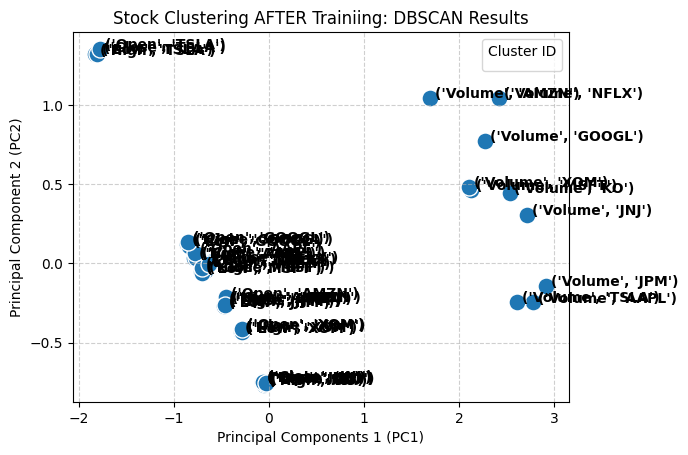

In [38]:
# Visualization AFTER Clustering (using the best model's results)
plt.Figure(figsize=(10,6))
# Use the assigned cluster labels to color the scatter plot
sns.scatterplot(x=pca_df["PC1"],y=pca_df["PC2"],palette="viridis",s=150,legend="full")

# Add Annotations (stock tickers)
for i, ticker in enumerate(pca_df.index):
    plt.annotate(ticker, (pca_df['PC1'][i] + 0.05, pca_df['PC2'][i]), 
                 fontsize=10, weight='bold')
    
plt.title(f"Stock Clustering AFTER Trainiing: {best_model_name} Results")
plt.xlabel("Principal Components 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.legend(title="Cluster ID",loc="upper right")
plt.grid(True,linestyle="--",alpha=0.6)
plt.show()